# Pareto NBD (Negative Binomial Distribution) model for customer life-time value

* This model will use historical transaction data to predict how valuable is a customer is in the future.
* CLV: Customer lifetime value refers to the total value a customer had for the company (profit generated by the customer).
* Pareto NBD can be extended to included more realtime features (covariates).

# Read Transactions

In [161]:
import pandas as pd

In [162]:
tr = pd.read_csv("../data/transactions.csv", parse_dates=["date"])

In [163]:
tr.head()

,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


# Compute the RFM Dataframe

<strong>It can be shown that the Pareto NBD model can be converted to a simpler model which requires the RFM DataFrame only, which is a memoriless version of the transactions from the point of view of the timestamp we are looking from.</strong>

In this section, we will generate the recency-frequency-monetary value (RFM) object.
    * Recency : time between first and last transaction
    * Frequency : here frequency really refers to repeat frequency, i.e. the number of purchases beyond the initial one. i.e. repeat frequency = purchase counts - 1 )
    * monetary value : mean of all the transactions in the training periods
    * T : time between first purchase and end of calibration period

In [164]:
def compute_rfm(x, timestamp): 
    x['recency'] = (x['date'].max() - x['date'].min()).days
    x['frequency'] = x['date'].count()-1
    x['T'] = (timestamp - x['date'].min()).days
    x['monetary_value'] = x['sales'].mean()
    return x[0:1]

In [165]:
train = tr[tr.date <= pd.to_datetime('1997-12-31')]
train = train.groupby("cust").apply(compute_rfm, pd.to_datetime('1997-12-31')) \
                             .reset_index(drop=True)

# Model

<img src="../img/pareto_nbd.png" />

In [166]:
import pystan

In [167]:
paretonbd_model="""
data{
    int<lower=1> n_cust;         # Number of customers 
    vector<lower=0>[n_cust] x;   # Frequency of purchases
    vector<lower=0>[n_cust] tx;  # Recency of purchases
    vector<lower=0>[n_cust] T;   # Time since last purchase
}

parameters{
    vector<lower=0,upper=1.0>[n_cust] la; # Purchase rate
    vector<lower=0,upper=1.0>[n_cust] mu; # Lifetime
}

model{
    # temporary variables
    vector[n_cust] like1; # likelihood
    vector[n_cust] like2; # likelihood

    # Priors for lambda and mu
    la ~ gamma(1, 10); 
    mu ~ gamma(1, 10);

    # The likelihood of the Pareto/NBD model
    like1 = x       .* log(la) + log(mu) - log(mu+la) - tx .* (mu+la);
    like2 = (x + 1) .* log(la) -           log(mu+la) - T  .* (la+mu);

    # Here we increment the log probability density (target) accordingly
    increment_log_prob(log(exp(like1) + exp(like2)));
}
"""

In [168]:
model = pystan.StanModel(model_code=paretonbd_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3350efce3d060542a138311c621bfc03 NOW.


In [172]:
samples = model.sampling(data={
    'n_cust': len(train),
    'x':      train['frequency'].values.tolist(),
    'tx':     train['recency'].values.tolist(),
    'T':      train['T'].values.tolist(),
}, warmup=500, iter=1000, chains=4)

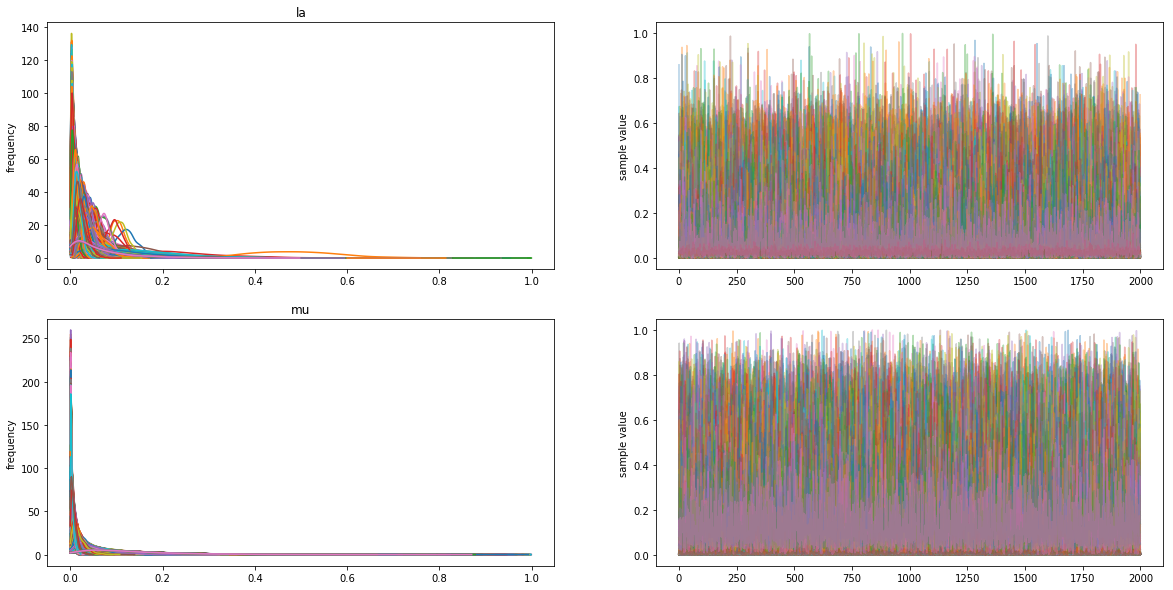

In [173]:
ax = samples.plot()
ax.set_size_inches(20, 10)

# Predicting the Future

* There is a closed form for predicting the future after having lambda and mu. But these can also be integrated in the model.
* The model is weak, it needs improving.

# Improving Pareto NBD

* Partial pooling.
* Hyper Priors.
* group-level predictors. 